# Customer Lifetime Value (CLV) Prediction
This notebook walks through the process of predicting customer lifetime value using the Online Retail dataset.


## 1. Data Loading
We begin by loading the dataset into a Pandas DataFrame and inspecting its shape and structure.


## 2. Data Cleaning
Handle missing values, remove invalid records, and prepare the dataset for analysis.


## 3. Exploratory Data Analysis (EDA)
- Distribution of Recency, Frequency, and Monetary values.
- Correlation heatmap.


## 4. Feature Engineering
- Compute Recency, Frequency, Monetary (RFM).
- Derive Average Order Value (AOV).


## 5. Model Training
We train regression models (RandomForest, XGBoost) to predict customer monetary value (LTV proxy).


## 6. Model Evaluation
Evaluate using MAE and RMSE. Visualize Actual vs Predicted values.


## 7. Feature Importance
Visualize which features contribute the most to the model using XGBoost/RandomForest feature importance.


## 8. Customer Segmentation
Divide customers into Low/Medium/High value segments based on predicted LTV.
Visualize the distribution of customer segments.


## 9. Save Results
Export final predictions and segments to CSV for business use.


## 10. Insights & Conclusion
- High-value customers form X% of the base but contribute Y% of revenue.
- Medium-value customers can be nurtured with loyalty programs.
- Low-value customers represent churn risk.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = r"D:\DIVYA\assessment\online_retail_II.xlsx"  
df = pd.read_excel(data)
df.shape

(525461, 8)

In [4]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.describe()

,Quantity,InvoiceDate,Price,Customer ID
count,525461.000000,525461,525461.000000,417534.000000
mean,10.337667,2010-06-28 11:37:36.845017856,4.688834,15360.645478
min,-9600.000000,2009-12-01 07:45:00,-53594.360000,12346.000000
25%,1.000000,2010-03-21 12:20:00,1.250000,13983.000000
50%,3.000000,2010-07-06 09:51:00,2.100000,15311.000000
75%,10.000000,2010-10-15 12:45:00,4.210000,16799.000000
max,19152.000000,2010-12-09 20:01:00,25111.090000,18287.000000
std,107.424110,NaN,146.126914,1680.811316


In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [9]:
# Clean missing Customer ID
df = df.dropna(subset=["Customer ID"])

In [10]:
print(df.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [11]:
df['TotalAmount'] = df['Quantity'] * df['Price']

In [12]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

In [13]:
customer_df = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'count',                                       # Frequency
    'TotalAmount': 'sum'                                      # Monetary (Total spent)
}).reset_index()

customer_df.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalAmount': 'Monetary'
}, inplace=True)

# Average Order Value
customer_df['AOV'] = customer_df['Monetary'] / customer_df['Frequency']

In [14]:
X = customer_df[['Recency', 'Frequency', 'AOV']]
y = customer_df['Monetary']

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
!pip install xgboost

In [21]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 333.89066234956607
RMSE: 2854.408375446775


In [23]:
customer_df['PredictedLTV'] = xgb_model.predict(X)

# Divide into 3 segments (Low, Medium, High)
customer_df['Segment'] = pd.qcut(customer_df['PredictedLTV'], q=3, labels=['Low', 'Medium', 'High'])

print(customer_df.head())

   Customer ID  Recency  Frequency  Monetary        AOV  PredictedLTV Segment
0      12346.0       67         46    -64.68  -1.406087    -65.167183     Low
1      12347.0        3         71   1323.32  18.638310   1277.183838    High
2      12348.0       74         20    222.16  11.108000    218.043076     Low
3      12349.0       43        107   2646.99  24.738224   2567.026855    High
4      12351.0       11         21    300.93  14.330000    289.744904     Low


In [24]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

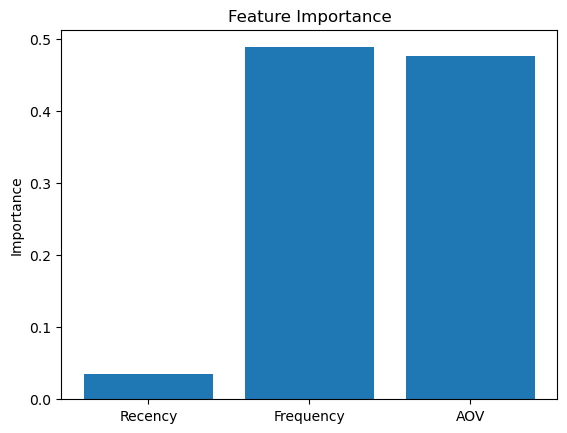

In [25]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importances
importances = rf_model.feature_importances_
features = X.columns

plt.bar(features, importances)
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.show()


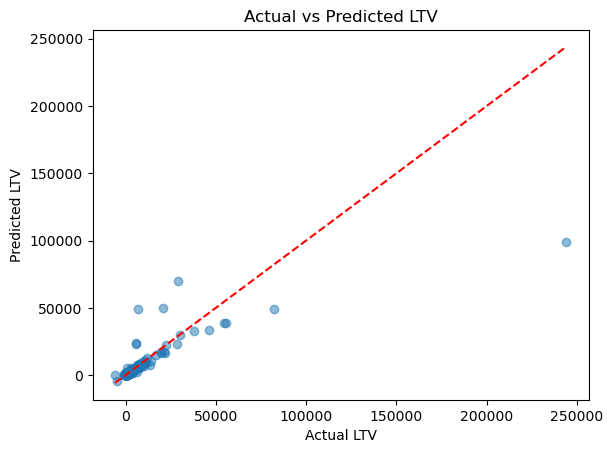

In [26]:
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel("Actual LTV")
plt.ylabel("Predicted LTV")
plt.title("Actual vs Predicted LTV")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')  # reference line
plt.show()


In [27]:
customer_df['PredictedLTV'] = rf_model.predict(X)

# Example segmentation: Low / Medium / High
customer_df['Segment'] = pd.qcut(customer_df['PredictedLTV'], q=3, labels=['Low', 'Medium', 'High'])

print(customer_df.head())


   Customer ID  Recency  Frequency  Monetary        AOV  PredictedLTV Segment
0      12346.0       67         46    -64.68  -1.406087    613.241421  Medium
1      12347.0        3         71   1323.32  18.638310   1217.598766  Medium
2      12348.0       74         20    222.16  11.108000    416.283000     Low
3      12349.0       43        107   2646.99  24.738224   2587.630112    High
4      12351.0       11         21    300.93  14.330000    416.283000     Low


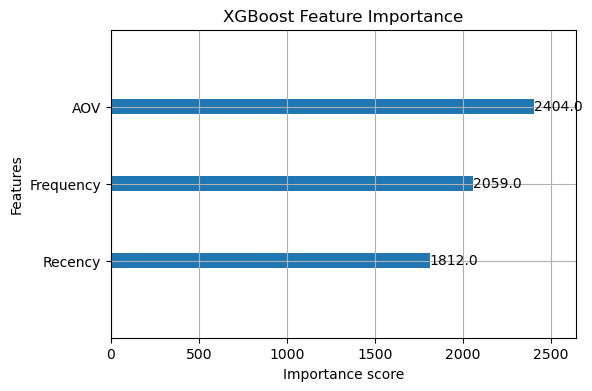

In [29]:
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_importance

# Train XGBoost model
xgb_model = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Plot feature importance
plt.rcParams['figure.figsize'] = [6, 4]
plot_importance(xgb_model, importance_type='weight')  # 'weight' = number of times feature is used
plt.title("XGBoost Feature Importance")
plt.show()
